# Машинное обучение, ФКН ВШЭ

## Домашнее задание 1. Разложение ошибки на смещение и разброс. Бэггинг, бустинг.

### Общая информация

Дата выдачи: 15.09.2025

Дедлайн: 23:59MSK 28.09.2025


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [20]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
boston = pd.read_csv("/content/drive/MyDrive/boston_house_prices.csv")

In [6]:
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [7]:
X = boston.drop(columns=["MEDV"]).to_numpy()
y = boston["MEDV"].to_numpy()

In [8]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) =
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] =
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [9]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

np.float64(34.361065493856906)

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка.

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$.

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$.

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [10]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)

    :returns: bias (float), variance (float), error (float)
    each value is computed using bootstrap
    """
    rng = np.random.default_rng(0)
    N = len(X)

    cnt = np.zeros(N, dtype=int)
    sum_p  = np.zeros(N, dtype=float)
    sum_p2 = np.zeros(N, dtype=float)
    sum_se = np.zeros(N, dtype=float)

    for i in range(num_runs):
      idx = rng.integers(0, N, size=N)
      oob = np.ones(N, dtype=bool)
      oob[np.unique(idx)] = False

      m = regressor.fit(X[idx], y[idx])
      pred = m.predict(X)

      if oob.any():
        p = pred[oob]
        sum_p[oob]+= p
        sum_p2[oob]+= p * p
        sum_se[oob]+= (p - y[oob]) *(p - y[oob])
        cnt[oob]+= 1
    ok = cnt > 0
    mean_pred = sum_p[ok] / cnt[ok]
    bias = ((mean_pred - y[ok])**2).mean()
    variance = ((sum_p2[ok]/cnt[ok]) - mean_pred**2).mean()
    error = (sum_se[ok]/cnt[ok]).mean()

    return (bias, variance, error)

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [13]:
models = {
  "LinearRegression": LinearRegression(),
  "DecisionTree": DecisionTreeRegressor(),
  "RandomForest": RandomForestRegressor(),
}

for name, model in models.items():
  bias, var, err = compute_biase_variance(model, X, y, num_runs=100)
  print(f"{name}  bias={bias:.4f}  var={var:.4f}  error={err:.4f}")

LinearRegression  bias=23.7677  var=0.9383  error=24.7060
DecisionTree  bias=11.0292  var=12.6220  error=23.6513
RandomForest  bias=10.5596  var=2.1397  error=12.6993


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__

Да, регрессия имеет маленький разброс и большое смещение, решающее дерево имеет смещение меньше и дисперсию больше, а вот суммарная ошибка у них примерно одинаковая, что нельзя сказать про рандомный лес, у него смещение выше, а дисперсия ниже, при это суммарная ошибка ниже.

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__

In [22]:
models = {
  "LinearRegression": LinearRegression(),
  "DecisionTree": DecisionTreeRegressor(),
  "RandomForest": RandomForestRegressor(),
}

M = 3
bagged = {
  f"Bagging({name})": BaggingRegressor(estimator=mdl, n_estimators=M)
  for name, mdl in models.items()
}


rows = []
for name, mdl in {**models, **bagged}.items():
  b2, var, err = compute_biase_variance(mdl, X, y, num_runs=100)
  rows.append((name, b2, var, err))

for r in rows: print(f"{r[0]}  bias={r[1]:.4f}  var={r[2]:.4f}  err={r[3]:.4f}")

LinearRegression  bias=23.7677  var=0.9383  err=24.7060
DecisionTree  bias=11.0414  var=12.7934  err=23.8348
RandomForest  bias=10.4732  var=2.1447  err=12.6179
Bagging(LinearRegression)  bias=23.8039  var=1.3056  err=25.1095
Bagging(DecisionTree)  bias=10.9423  var=6.3161  err=17.2584
Bagging(RandomForest)  bias=11.2729  var=1.6235  err=12.8964


Смещение практически не поменялось, как мы и обсуждали на лекции, а вот разброс для дерева решений и рандомного леса дисперсия не уменьшилась в 3 раза, то есть базовые алгоритмы имеют корреляцию.

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [16]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title="", ax = None):
    """
    plot graphics described above
    """
    rng = np.random.default_rng(0)
    n = len(X)

    test_idx  = rng.choice(n, size=num_test_objects, replace=False)
    train_idx = np.setdiff1d(np.arange(n), test_idx)
    X_train, y_train = X[train_idx], y[train_idx]
    X_test,y_test  = X[test_idx],y[test_idx]

    t = len(train_idx)
    preds = np.empty((num_runs, num_test_objects), dtype=float)
    for r in range(num_runs):
      row = rng.integers(0, t, size=t)
      model = regressor.fit(X_train[row], y_train[row])
      preds[r] = model.predict(X_test)

    for j in range(num_test_objects):
      ax.scatter(np.full(num_runs, j), preds[:, j], s=12, alpha=0.6)
      ax.scatter(j, y_test[j], c="k", marker="x", s=36)

    ax.set_xlabel("index")
    ax.set_ylabel("prediction")
    ax.set_title(title)
    ax.set_xticks(np.arange(num_test_objects))
    plt.tight_layout()
    return ax

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

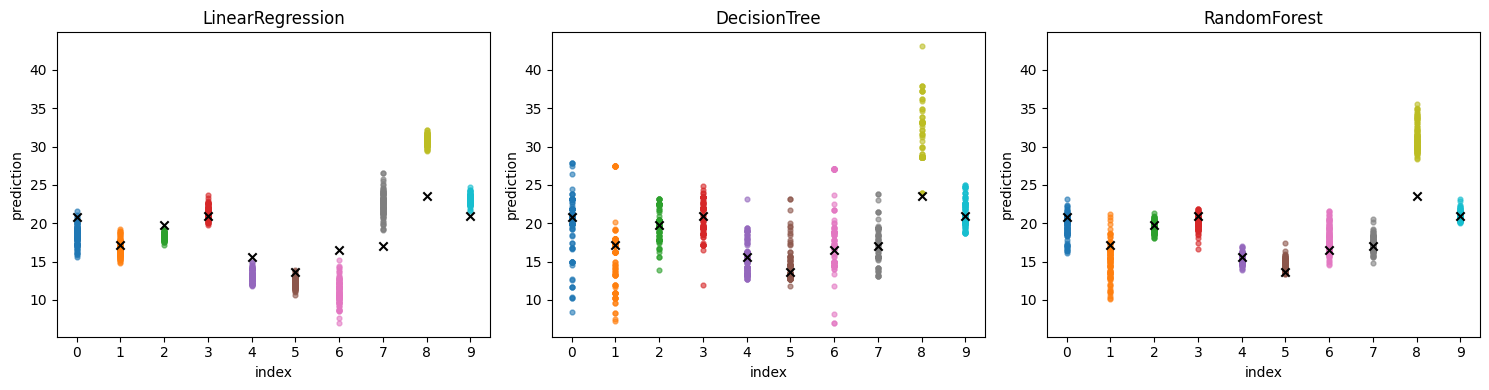

In [18]:
fig = plt.figure(figsize=(15, 4))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharey=ax1)
ax3 = plt.subplot(1, 3, 3, sharey=ax1)

plot_predictions(LinearRegression(), X, y, num_runs=100, title="LinearRegression",ax=ax1)
plot_predictions(DecisionTreeRegressor(), X, y, num_runs=100, title="DecisionTree",ax=ax2)
plot_predictions(RandomForestRegressor(), X, y, num_runs=100, title="RandomForest",ax=ax3)

plt.tight_layout()
plt.show()

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма.

__Your answer here:__

Для регрессии в основном небольшой разброс и большое смещение, для решающего дерева разброс уже выше, но меньше смещение, для рандомного леса всё уже намного лучше, видно небольшой разброс и небольшое смещение.

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

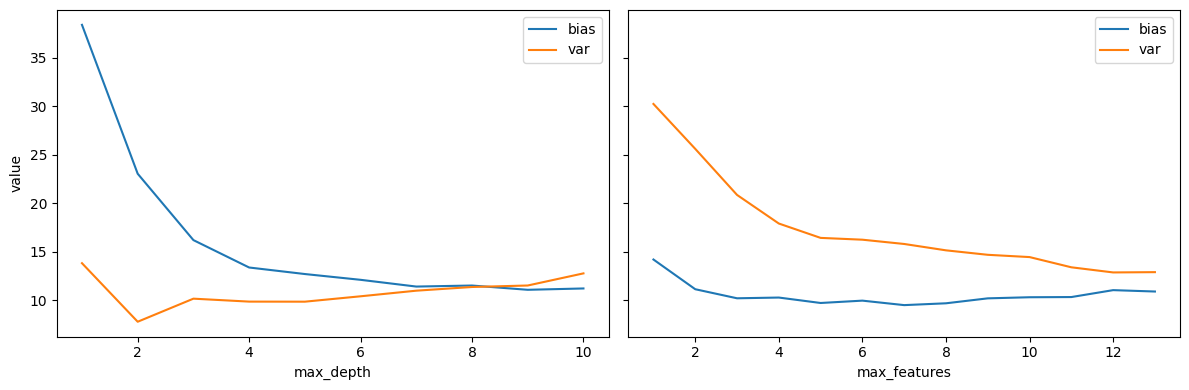

In [19]:
depths = range(1, 11)
b2_d, var_d = [], []
for d in depths:
  b2, var, _ = compute_biase_variance(DecisionTreeRegressor(max_depth=d), X, y, num_runs=100)
  b2_d.append(b2); var_d.append(var)

p = X.shape[1]
mfs = range(1, p+1)
b2_f, var_f = [], []
for m in mfs:
  b2, var, _ = compute_biase_variance(DecisionTreeRegressor(max_features=m), X, y, num_runs=100)
  b2_f.append(b2); var_f.append(var)

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
ax[0].plot(list(depths), b2_d, label='bias'); ax[0].plot(list(depths), var_d, label='var'); ax[0].set_xlabel('max_depth'); ax[0].legend()
ax[1].plot(list(mfs),   b2_f, label='bias'); ax[1].plot(list(mfs),   var_f, label='var'); ax[1].set_xlabel('max_features'); ax[1].legend()
ax[0].set_ylabel('value'); plt.tight_layout()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

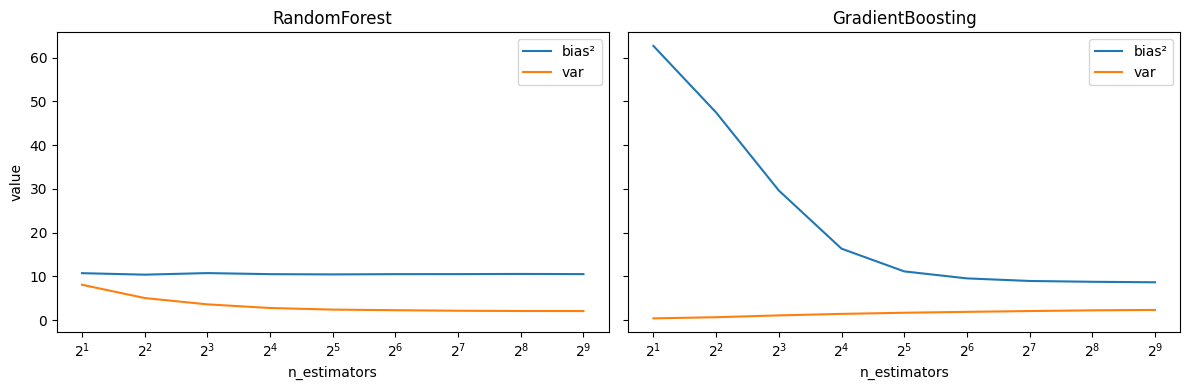

In [21]:
grid = 2 ** np.arange(1, 10)

b2_rf, var_rf = [], []
for n in grid:
  b2, var, _ = compute_biase_variance(RandomForestRegressor(n_estimators=int(n)), X, y, num_runs=100)
  b2_rf.append(b2); var_rf.append(var)

b2_gb, var_gb = [], []
for n in grid:
  b2, var, _ = compute_biase_variance(GradientBoostingRegressor(n_estimators=int(n)), X, y, num_runs=100)
  b2_gb.append(b2); var_gb.append(var)

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
ax[0].plot(grid, b2_rf, label='bias'); ax[0].plot(grid, var_rf, label='var'); ax[0].set_title('RandomForest'); ax[0].legend()
ax[1].plot(grid, b2_gb, label='bias'); ax[1].plot(grid, var_gb, label='var'); ax[1].set_title('GradientBoosting'); ax[1].legend()
ax[0].set_xscale('log', base=2); ax[1].set_xscale('log', base=2)
ax[0].set_ylabel('value'); ax[0].set_xlabel('n_estimators'); ax[1].set_xlabel('n_estimators')
plt.tight_layout()

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

1. При росте глубины дерева смещение уменьшается, а дисперсия растёт, поскольку модель становится гибче. Для max_features дисперсия снижается, поскольку стабильнее выбирается сплит, а смещение в целом не меняется.

2. Для рандомного леса снижается дисперсия с количеством деревьев, а вот для градиентного бустинга дисперсия не меняется, а смещение уменьшается, то есть модель становится гибче.